In [1]:
from autobound.causalProblem import causalProblem
from autobound.DAG import DAG
import sys
import os
notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
# Add the parent directory to the Python path
sys.path.append(parent_dir)

import pandas as pd
from autobound.Query import Query
import numpy as np

import pyomo.environ as pyo
import io 
from copy import deepcopy
from multiprocessing import Process,Pool
import time
import sys
from autobound.Program import pyomo_symb,mult_params_pyomo,parse_bounds,solve1
import matplotlib.pyplot as plot
from sklearn.linear_model import LogisticRegression
from utils import return_prob_df, train_fairness_classifiers,return_prob_df_unselected,calc_disparity_metric
from src.construct_fairness_metrics import get_metric_expressions

In [21]:
def get_causal_fairness_metrics(problem,query):

    if query == "TE":
        return (problem.query('Q(A=1)=1') + problem.query('Q(A=0)=1', -1),Query(1)
)
    if query == "CF":
        return (problem.query('Q(A=1)=1&Q(A=0)=1') + problem.query('Q(A=1)=0&Q(A=0)=0'),Query(1))
    
    if query == "SE":
        return (problem.query('Q(A=1)=1')*problem.query('A=1') + problem.query('Q=1&A=0',-1), Query(1))

def get_causal_constraint(problem,query,val):

    if query == "TE":
        return (problem.query('Q(A=1)=1&S=1') + problem.query('Q(A=0)=1&S=1', -1) + Query(val)*problem.query('S=1', -1)
)
    if query == "CF":
        return problem.query('Q(A=1)=1&Q(A=0)=1&S=1') + problem.query('Q(A=1)=0&Q(A=0)=0&S=1') + Query(val)*problem.query('S=1', -1)
    
    if query == "SE":
        return problem.query('Q(A=1)=1&S=1')*problem.query('A=1&S=1') + problem.query('Q=1&A=0&S=1',-1) + Query(val)*problem.query('S=1', -1)

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
sns.set_theme()
sns.set_style("whitegrid")

In [15]:
ds = np.load("/Users/njwfish/Dropbox/Testing_fairness/data/dutch.abroca.npz")
X, y, A = ds["X"], ds["y"], ds["A"]
perm = np.random.choice(y.shape[0], size=(y.shape[0],), replace=False)
prop = int(0.5 * y.shape[0])

X_train, y_train, A_train = X[perm][:-prop], y[perm][:-prop], A[perm][:-prop]
X_test, y_test, A_test = X[perm][-prop:], y[perm][-prop:], A[perm][-prop:]

In [16]:
prob_df

,A,Y,P,prob
0,0,0,0,0.254585
1,0,0,1,0.081430
2,0,1,0,0.026713
3,0,1,1,0.135584
4,1,0,0,0.167958
5,1,0,1,0.018305
6,1,1,0,0.115756
7,1,1,1,0.199669


In [6]:
classifiers = train_fairness_classifiers(X_train,y_train,A_train,disparity_metric="DP")
prob_df = return_prob_df(classifiers[0],X_test,y_test,A_test)
prob_df.rename(columns={"Z":"Y"},inplace=True)

/Users/njwfish/fragile.ml/.conda/lib/python3.11/site-packages/fairlearn/reductions/_moments/utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
/Users/njwfish/fragile.ml/.conda/lib/python3.11

In [22]:

# missingness_prob = 0.05

def run_causal_fairness(prob_df,CF_metric,missingness_prob):
    if "Z" in prob_df.columns:
        prob_df["Y"] = prob_df["Z"]
        prob_df = prob_df.drop("Z",axis=1)

    if "P" in prob_df.columns:
        prob_df["Q"] = prob_df["P"]
        prob_df = prob_df.drop("P",axis=1)

    selec_prob_df = prob_df.copy()
    selec_prob_df["S"] = 1 
    selec_prob_df["prob"] = (1-missingness_prob)*selec_prob_df["prob"]

    dag = DAG()
    dag.from_structure("A->Y, A->Q, A->Y, U->Q, U->Y, U->S, Y->S" ,unob="U")
    # dag.from_structure("A -> S, A -> Y,A -> Q, U->Q, U->Y" ,unob="U")


    problem = causalProblem(dag)

    numerator, denominator = get_causal_fairness_metrics(problem, CF_metric)
    # numerator, denominator = get_metric_expressions(problem, CF_metric, outcome_variable="Q")

    if CF_metric == "CF":
        constraint = get_causal_constraint(problem,"CF", 0.1)
        problem.add_constraint(constraint=constraint,symbol="==")
    # problem.add_constraint(constraint=Query(-1)*constraint,symbol="<=")
    problem.load_data(selec_prob_df)

    problem.add_prob_constraints()

    problem.set_estimand(numerator, div=denominator)

    program = problem.write_program()
    try:
        result = program.run_pyomo('ipopt',verbose=False)
    except:
        result = (None,None,True,True)
    return result

In [38]:
selection_cf = {
    "dag_str": "A->Y, A->Q, A->Y, U->Q, U->Y, U->S, Y->S",
    "unob": ["U"],
    "constraints": ["P(S = 1) >= 1 - D", "P(Q(A=1)=1&P(A=0)=1&S=1) + P(Q(A=1)=0&Q(A=0)=0&S=1) - D * P(S=1) == 0"],
    "cond_nodes": ["S"],
    "attribute_node": "A",
    "outcome_node": "Y",
    "prediction_node": "Q"
}
selection_se = {
    "dag_str": "A->Y, A->Q, A->Y, U->Q, U->Y, U->S, Y->S",
    "unob": ["U"],
    "constraints": ["P(S = 1) >= 1 - D"],
    "cond_nodes": "S",
    "attribute_node": "A",
    "outcome_node": "Y",
    "prediction_node": "Q"
}
selection_te = {
    "dag_str": "A->Y, A->Q, A->Y, U->Q, U->Y, U->S, Y->S",
    "unob": ["U"],
    "constraints": ["P(S = 1) >= 1 - D"],
    "cond_nodes": "S",
    "attribute_node": "A",
    "outcome_node": "Y",
    "prediction_node": "Q"
}
configs = {
    "CF": selection_cf,
    "SE": selection_se,
    "TE": selection_te
}

In [36]:
from src.analyze_metric_sensitivity import analyze_metric_sensitivity
prob_df.rename(columns={"P":"Q"}, inplace=True)
results = analyze_metric_sensitivity(prob_df.copy(), 'CF', sensitivity_parameter_values=[0.02, 0.1], **selection_cf)
results

model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.14.16\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.14.16\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.14.16\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.14.16\x3a Converged to a locally infeasible
      point. Problem may be infeasible.


(0.09338314108435243, 0.09941705291878968, False, False)

In [34]:
run_causal_fairness(prob_df[['A','Y','Q','prob']],"CF",0.02)

model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.14.16\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.14.16\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.14.16\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.14.16\x3a Converged to a locally infeasible
      point. Problem may be infeasible.


(0.09750649001754846, 0.09750649002034636, False, False)

In [15]:
run_causal_fairness(prob_df,"CF",0.2)

(0.07999990343396257, 0.2745820802160575, True, True)

In [40]:
prob_df

,A,Y,Q,prob,S
0,0,0,0,0.254585,1
1,0,0,1,0.081430,1
2,0,1,0,0.026713,1
3,0,1,1,0.135584,1
4,1,0,0,0.167958,1
5,1,0,1,0.018305,1
6,1,1,0,0.115756,1
7,1,1,1,0.199669,1


CF
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.14.16\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.14.16\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.14.16\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.14.16\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
CF 0.0424822962501278 0.09142222459446195
CF
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.14.16\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
model.name="unknown";
    - termination conditi

TypeError: object of type 'numpy.int64' has no len()

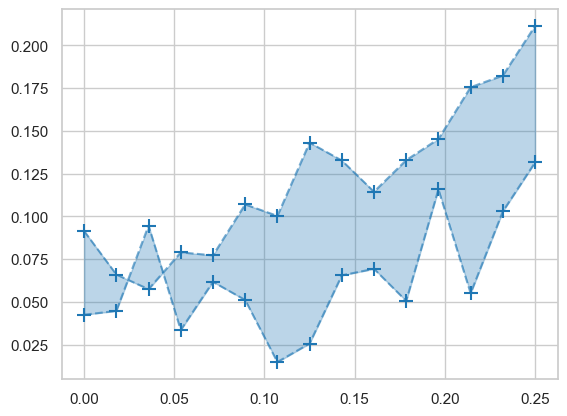

In [42]:
metrics = ["CF", "SE", "TE"]
colours = sns.color_palette("tab10", 3)

fig, ax = plt.subplots(nrows=1,ncols=1,sharey=True,figsize= (25.6/4,4.8 ))

range_curve = np.linspace(0,0.1,200)
range_ab = np.linspace(0,0.25,15)
for i, metric in enumerate(metrics):
    lower_results = []
    upper_results = []
    for val in range_ab:
        print(metric)
        sens_results = analyze_metric_sensitivity(prob_df.copy(), metric, sensitivity_parameter_values=[val, 0.1], **configs[metric])
        lower_results.append(sens_results[0])
        upper_results.append(sens_results[1])
        print(metric, sens_results[0], sens_results[1])
    ax.fill_between(range_ab, lower_results, upper_results, alpha=.3,color = colours[i])
    ax.plot(range_ab, upper_results, ls='--', alpha=.6,color=colours[i])
    ax.plot(range_ab, lower_results, ls='--', alpha=.6,color=colours[i])
    ax.scatter(range_ab, upper_results, ls='-', marker='+', s=100,alpha=1,color=colours[i])
    ax.scatter(range_ab, lower_results, ls='-', marker='+', s=100,alpha=1,color=colours[i])


legend_elements = [
    Patch(facecolor=colours[0], label='Color Patch'),
    Patch(facecolor=colours[1], label='Color Patch'),
    Patch(facecolor=colours[2], label='Color Patch'),
]
legend_titles = metrics 
leg = ax.legend(legend_elements,legend_titles,loc="upper left",ncol=2,fontsize ="10")
ax.set_title("Causal Fairness Metrics Under Selection On Adult Dataset")
ax.set_xlabel(r"$P(S=0)$")
ax.set_ylabel("Metric Value")